# D'autres types d'agents...

In [1]:
from atom import *
from data_processing import *
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stats
plt.rcParams['figure.figsize'] = (15,10)

## ZIT avec des probabilités d'ask et de bid différentes

On peut créer des ZIT ayant des probabilités d'envoyer des asks / d'envoyer des bids différentes de $\dfrac{1}{2}$. On peut aussi choisir l'intervalle dans lequel il tirent le prix (initiallement $[\![1000,9999]\!]$) et la quantité (initiallement $[\![1,9]\!]$). Pour ce faire, on va utiliser les paramètres p_min, p_max, q_min, q_max, pb_ask et pb_bid. Si pb_ask + pb_bid < 1, alors le ZIT n'enverra aucun ordre avec une probabilité 1- (pb_ask + pb_bid).

In [2]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file, trace=['wealth'])
t1 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.5, pb_bid=0.5)
t2 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.1, pb_bid=0.1)
m.add_trader(t1)
m.add_trader(t2)
for i in range(200):
    m.run_once()
m.print_state()
file.close()

print(t1.get_infos(m))
print(t2.get_infos(m))

ZIT 1:
Cash: -273
Apple: -8
Wealth: -4849

ZIT 2:
Cash: 273
Apple: 8
Wealth: 4849



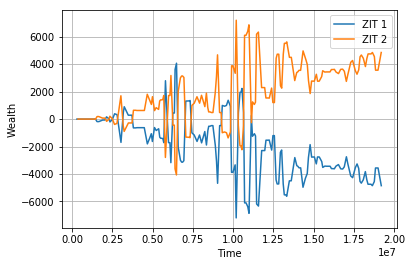

In [3]:
Wealths = extract_wealths('trace.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

## Un autre type de ZIT...

On va créer un type de ZIT à deux paramètres `delta` et `pb_cancel`. Ce ZIT va envoyer avec une probabilité pb_cancel un ordre `CancelMyOrders`, qui annule tous ses ordres dans un carnet d'ordre donné, et avec probabilité 1 - pb_cancel, il va envoyer un `LimitOrder` pour lequel il va choisir le prix uniformément entre $p(1-\delta)$ et $p(1+\delta)$, où p est le dernier prix fixé pour l'asset.

In [4]:
class ZITPeriodique(Trader):
    def __init__(self, market, initial_assets=None, cash=0, periode=1):
        Trader.__init__(self, market, initial_assets, cash)
        self.periode = periode
    def __str__(self):
        return "ZITdelta %i" % self.trader_id
    def decide_order(self, market, asset):
        
        if ((market.time+1)%self.periode==0):
            return LimitOrder(asset, self, random.choice(['ASK', 'BID']), random.randint(1000,9999), random.randint(1, 9))
        else:
            return None 

In [5]:
class ZITTrader_delta(Trader):
    def __init__(self, market, initial_assets=None, cash=0, delta=0.05, pb_cancel=0.1):
        Trader.__init__(self, market, initial_assets, cash)
        self.delta = delta
        self.pb_cancel = pb_cancel
    def __str__(self):
        return "ZITdelta %i" % self.trader_id
    def decide_order(self, market, asset):
        r = random.random() # 0 <= r < 1
        if r < self.pb_cancel:
            return CancelMyOrders(asset, self)
        else:
            last_price = market.prices[asset] if market.prices[asset] != None else 150
            price = random.randint(max(100, int((1-self.delta)*last_price)), max(int(100*(1+2*self.delta)), 1+int((1+self.delta)*last_price)))
            return LimitOrder(asset, self, random.choice(['ASK', 'BID']), price, random.randint(1, 9))

Remarque : le fait qu'on impose un prix min (plus ou moins 100) a une justification pratique : comme nos prix sont des entiers, si on n'impose pas de prix plancher, une fois qu'un prix sera bas, il le restera très souvent. On peut justifier ce prix plancher en disant qu'il représente la plus petite unité de monnaie dont on dispose : un centime.

Remarque 2 : si on change la borne sup du prix `1+int((1+self.delta)*last_price)` en `1+int(x0+(1+self.delta)*last_price)` avec x0 > 0, on obtient une courbe "globalement croissante" dans le temps.

In [6]:
file = open('trace.dat', 'w')
m = Market(['Apple', 'Google'], out=file, trace=['price'], fix='S')
for i in range(10):
    #m.add_trader(ZITTrader_delta(m, delta=0.05, pb_cancel=0.1))
    m.add_trader(ZITPeriodique(m,periode=random.randint(1,5)))
for i in range(100):
    m.run_once()
file.close()

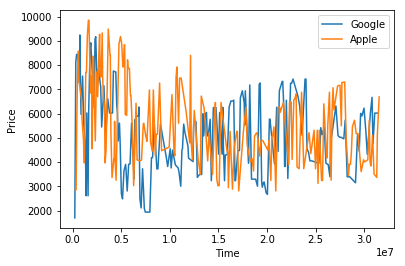

In [7]:
Prices = extract_prices('trace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

## ZIT ne se ruinant pas

Nos ZITs peuvent à la fois avoir un cash négatif et une quantité d'actions négative. Nous allons faire des ZIT qui ne se ruinent pas en respectant le principe suivant : un agent ne place pas d'ordre tant qu'il lui reste un ordre dans un carnet d'ordre.

In [8]:
class ZITTrader_v2(Trader):
    def __init__(self, market, initial_assets=None, cash=0):
        Trader.__init__(self, market, initial_assets, cash)
    def __str__(self):
        return "ZITv2 " + super().__str__()
    def decide_order(self, market, asset):
        # On compte le nombre d'ordres placés dans les orderbooks par cet agent...
        nb_placed_orders = sum(len([o for o in market.orderbooks[asset2].asks.tree+market.orderbooks[asset2].bids.tree if o.source == self]) for asset2 in market.orderbooks.keys())
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            if direction == 'ASK' and self.assets[asset] > 0: # Si on a quantité > 0 d'actions pour cet asset...
                # On ne vend pas une quantité d'actions > à celle qu'on a.
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, min(self.assets[asset], 9)))
            elif direction == 'BID' and self.cash >= 1000: # Pour acheter, il faut de l'argent...
                price = random.randint(1000, min(self.cash, 9999))
                # On n'achète pas pour un volume > au cash qu'on a.
                return LimitOrder(asset, self, 'BID', price, random.randint(1, min(self.cash//price, 9)))
        return None # Dans tous les autres cas, on ne place pas d'ordre.

Remarque : La façon de compter le nombre d'ordres placés par l'agent n'est clairement pas optimisée. À chaque fois qu'il faut placer un ordre, on fait $\Theta(\sum_{a\in Assets}|\text{Orderbook}_a|)$ opérations... Il suffirait d'ajouter un attribut booléen à la classe `ZITTrader_v3` qui garde en mémoire si un ordre est placé, et qui est modifée par la méthode `market.match` dès que cet ordre est retiré d'un carnet d'ordre. Ce n'est pas fait ici, car c'est plus compliqué à faire, et on va voir que ces ZIT ne vont pas avoir un comportement satisfaisant, et donc on ne pas s'en servir.

On va vérifier que ce ZIT fait bien ce qu'on veut sur des exemples simples. On va d'abord regarder ce qu'il se passe si on initialise les agents sans cash ni actions. Ils ne devraient placer aucun ordre.

In [9]:
m = Market(['Apple'])
t = ZITTrader_v2(m)
m.add_trader(t)
m.run_once()
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;ZITv2 13;0;Apple:0
AgentWealth;ZITv2 13;0;402432
Tick;1;486656
# Nb orders received: 0
# Nb fixed prices: 0
# Leaving ask size: 0
# Leaving bid size: 0


Des agents qui n'ont que du cash vont envoyer soit rien, soit des ordres bid.

In [10]:
m = Market(['Apple'])
t = ZITTrader_v2(m, cash=10000)
m.add_trader(t)
for i in range(3):
    m.run_once()
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;ZITv2 14;10000;Apple:0
AgentWealth;ZITv2 14;10000;302592
Tick;1;355584
Tick;2;371968
Tick;3;384256
# Nb orders received: 0
# Nb fixed prices: 0
# Leaving ask size: 0
# Leaving bid size: 0


Des agents qui n'ont que des actions vont envoyer soit rien, soit des ordres ask.

In [11]:
m = Market(['Apple'])
t = ZITTrader_v2(m, initial_assets=[50])
m.add_trader(t)
for i in range(3):
    m.run_once()
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;ZITv2 15;0;Apple:50
AgentWealth;ZITv2 15;250000;466176
Tick;1;516864
LimitOrder;Apple;ZITv2 15;ASK;9558;6;542976
Tick;2;560384
Tick;3;571904
# Nb orders received: 1
# Nb fixed prices: 0
# Leaving ask size: 1
# Leaving bid size: 0


Maintenant qu'on sait que notre ZIT fonctionne comme on le veut, on va désormais faire une simulation avec plusieurs agents et plusieurs tours de parole et afficher les prix.

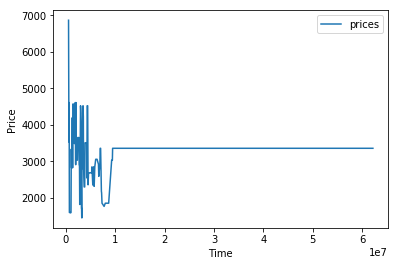

In [12]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file, trace=['price'])
for i in range(100):
    m.add_trader(ZITTrader_v2(m, initial_assets=[50], cash=10000))
for i in range(100):
    m.run_once()
m.print_last_prices()
m.print_state()
file.close()

T, P = extract_prices('trace.dat')['Apple']
plt.plot(T, P, '-',label="prices")
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

Très rapidement, plus aucun prix n'est fixé, car chaque agent attend que son ordre soit exécuté.
On peut faire un `cat trace.dat | grep -E 'Price;|Tick;'` dans la console pour ne récupérer que les lignes commençant par "Tick;" ou par "Price;" pour voir quand ont été fixés les prix.

Remarque : Comme des lignes "Price;..." ne sont écrites que lorsqu'un prix est fixé, on est obligé de forcer le marché à afficher le dernier prix de l'asset (avec `m.print_last_prices()`) à la fin de la simulation pour voir que les prix n'évoluent plus à partir d'un certain moment. (Si on ne le faisait pas, on obtiendrait la même courbe, mais tronquée : on n'aurait pas la partie stationnaire.)

## Agent chartist

Un agent chartist possède deux paramètres $m < M$. En notant, $\widehat{p_t}(n)$ la moyenne des prix $p_{t-n}, \ldots, p_{t-1}$, l'agent choisi l'ordre à envoyer de la façon suivante :
* Si $\widehat{p_t}(m) > \widehat{p_t}(M)$, alors la tendance du prix est à la hausse et l'agent envoie un bid.
* Si $\widehat{p_t}(m) < \widehat{p_t}(M)$, alors la tendance du prix est à la baisse et l'agent envoie un ask.
* Si $\widehat{p_t}(m) = \widehat{p_t}(M)$, alors l'agent n'envoie pas d'ordre.

In [13]:
class Chartist(Trader):
    def __init__(self, market, initial_assets=None, cash=0, m=3, M=5):
        Trader.__init__(self, market, initial_assets, cash)
        self.m = m
        self.M = M
    def __str__(self):
        return "Chartist " + super().__str__()
    def decide_order(self, market, asset):
        def mean_price(n):
            P = market.prices_hist[asset]
            if len(P) >= n:
                s = sum([P[-i] for i in range(n)])
                return s/n
            return None
        mean_m = mean_price(self.m)
        mean_M = mean_price(self.M)
        if mean_m != None and mean_M != None:
            if mean_m > mean_M:
                return LimitOrder(asset, self, 'BID', random.randint(1000, 9999), random.randint(1, 9))
            elif mean_m < mean_M:
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, 9))
        return None

In [14]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file)
for i in range(2):
    m.add_trader(Chartist(m))
for i in range(2):
    m.add_trader(ZITTrader(m))
for i in range(100):
    m.run_once()
m.print_state()
file.close()

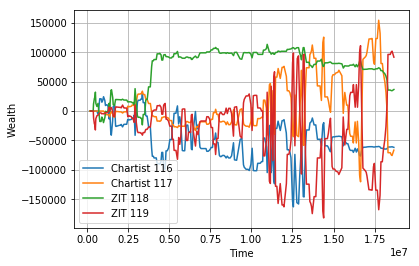

In [15]:
Wealths = extract_wealths('trace.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

On va regarder si un chartist a en moyenne un wealth plus élevé qu'un ZIT :

In [16]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file, trace=['wealth', 'price'])
for i in range(90):
    m.add_trader(Chartist(m, m=2, M=5))
for i in range(10):
    m.add_trader(ZITTrader(m))
for i in range(200):
    m.run_once()
m.print_state()
file.close()

In [17]:
Wealths = extract_wealths('trace.dat')
Mean_wealth_chartist = []
Mean_wealth_ZIT = []
for agent in Wealths.keys():
    _, W = Wealths[agent]
    if "Chartist" in agent:
        Mean_wealth_chartist.append(np.mean(np.array(W)))
    else:
        Mean_wealth_ZIT.append(np.mean(np.array(W)))
print("Wealth moyen des chartists : %i\nWealth moyen des ZIT : %i\n" % (np.mean(np.array(Mean_wealth_chartist)), np.mean(np.array(Mean_wealth_ZIT))))

Wealth moyen des chartists : -26431
Wealth moyen des ZIT : 237887



/home/m2mocad/fleurya/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


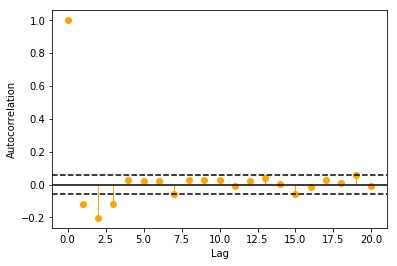

In [18]:
Prices = np.array(extract_prices('trace.dat')['Apple'][1])
Returns = np.log(Prices[1:]) - np.log(Prices[:-1])
acf = stats.acf(Returns, nlags=20)
plt.plot(range(21), acf, 'o', color="orange")
plt.bar([x+0.02 for x in range(21)], acf, .04, color="orange")
plt.axhline(0, color='k')
sigma = max(np.abs(acf[10:]))
plt.axhline(sigma, color='k', linestyle='--')
plt.axhline(-sigma, color='k', linestyle='--')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Nos chartists ont l'air de faire moins bien que des ZITs...

## Agent automate

On va créer un agent qui va prendre en paramètre un pile d'ordre et qui, à chaque fois qu'il aura la parole, renverra l'ordre au sommet de la pile.

In [19]:
class Automaton(Trader):
    def __init__(self, market, orders_dict=dict(), initial_assets=None, cash=0, name=None):
        '''orders_dict est un dictionnaire dont les clés sont les assets et les valeurs des listes de la forme (direction,price,qty)'''
        Trader.__init__(self, market, initial_assets, cash, name=name)
        self.orders = orders_dict
    def __str__(self):
        return self.name if self.name != None else "Automaton "+ super().__str__()
    def decide_order(self, market, asset):
        if asset not in self.orders.keys() or self.orders[asset] == []:
            return None
        else:
            d, p, q = self.orders[asset].pop(0)
            return LimitOrder(asset, self, d, p, q)

In [20]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file, trace=['wealth'])
# On ajoute un agent automate qui envoie en alternance un ordre de vente à 6000 et une ordre d'achat à 4000 (toujours avec une quantité de 9) 
m.add_trader(Automaton(m, orders_dict={'Apple': [('ASK', 6000, 9), ('BID', 4000, 9)]*50}, name='juliette'))
# On ajoute un autre agent automate qui envoie en alternance un ordre de vente à 4000 et une ordre d'achat à 6000 (toujours avec une quantité de 9) 
m.add_trader(Automaton(m, orders_dict={'Apple': [('ASK', 4000, 9), ('BID', 6000, 9)]*50}, name='paul'))
# On rajoute deux ZITs
for i in range(2):
    m.add_trader(ZITTrader(m))
for i in range(100):
    m.run_once()
m.print_state()
file.close()

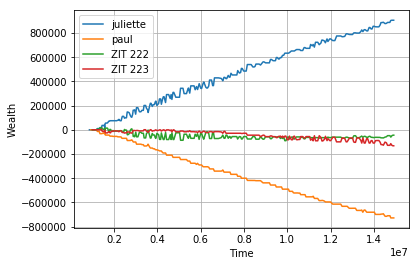

In [21]:
Wealths = extract_wealths('trace.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

On observe qu'un des deux automates a un wealth qui croît (c'est celui qui vend à 6000 et achète à 4000) et que l'autre décroît (celui qui vend à 4000 et achète à 6000).

## Agent arbitragist

In [22]:
class Arbitragist(Trader):
    def __init__(self, market, initial_assets=None, cash=0, period=2):
        Trader.__init__(self, market, initial_assets, cash)
        self.period = max(period, 2)
        self.time = period-1
    def __str__(self):
        return "Arbitragist " + super().__str__()
    def decide_order(self, market, asset):
        self.time += 1
        if self.time == self.period: # Si on a passé une période, on a annule tous nos ordres non encore exécutés
            self.time = 0
            return CancelMyOrders(asset, self)
        elif self.time == 1: # Si on vient d'annuler nos ordres, on envoie notre ordre...
            w = self.get_wealth(market)
            p = market.prices[asset]
            if p != None:
                q = w//(len(market.orderbooks.keys())*p) - self.assets[asset]
                # w//(len(market.orderbooks.keys())*p) représente la quantité d'actions de asset que l'agent devrait
                # avoir s'il voulait répartir équitablement tout son wealth sur l'ensemble des assets
                if q != 0:
                    return LimitOrder(asset, self, 'ASK' if q > 0 else 'BID', p, np.abs(q))
        return None

In [23]:
file = open('trace.dat', 'w')
m = Market(['Apple', 'Google', 'Microsoft'], out=file)
m.add_trader(ZITTrader(m, [5, 5, 5], cash=100000))
m.add_trader(Chartist(m, [5, 5, 5], cash=100000))
m.add_trader(Arbitragist(m, [5, 5, 5], cash=100000, period=10))
for i in range(100):
    m.run_once()
m.print_state()
file.close()

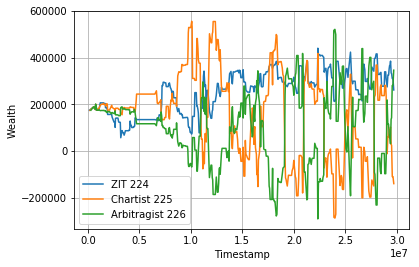

In [24]:
Wealths = extract_wealths('trace.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Timestamp')
plt.ylabel('Wealth')
plt.show()

On va comparer les wealths moyens des chartists, arbitragists et des ZITs :

In [25]:
file = open('trace.dat', 'w')
m = Market(['Apple', 'Google', 'Microsoft'], out=file, trace=['wealth'])
for i in range(20):
    m.add_trader(ZITTrader(m, [10, 10, 10], cash=10000))
    m.add_trader(Chartist(m, [10, 10, 10], cash=10000, m=2, M=5))
    m.add_trader(Arbitragist(m, [10, 10, 10], cash=10000, period=10))
for i in range(100):
    m.run_once()
m.print_state()
file.close()

In [26]:
Wealths = extract_wealths('trace.dat')
Mean_wealth_arbitragist = []
Mean_wealth_chartist = []
Mean_wealth_ZIT = []
for agent in Wealths.keys():
    _, W = Wealths[agent]
    if "Chartist" in agent:
        Mean_wealth_chartist.append(np.mean(np.array(W)))
    elif "Arbitragist" in agent:
        Mean_wealth_arbitragist.append(np.mean(np.array(W)))
    else:
        Mean_wealth_ZIT.append(np.mean(np.array(W)))
print("Wealth moyen des arbitragists : %i\nWealth moyen des chartists : %i\nWealth moyen des ZITs : %i\n" % (np.mean(np.array(Mean_wealth_arbitragist)), np.mean(np.array(Mean_wealth_chartist)), np.mean(np.array(Mean_wealth_ZIT))))

Wealth moyen des arbitragists : 113911
Wealth moyen des chartists : 60896
Wealth moyen des ZITs : 323348



## Tracer un faisceau de courbes de prix

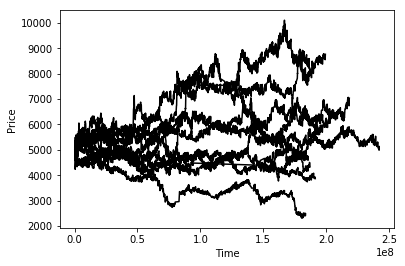

In [27]:
nb_simulations = 10
for i in range(nb_simulations):
    file = open('trace.dat', 'w')
    m = Market(['Apple'], out=file, trace=['price'], fix='S')
    for i in range(10):
        m.add_trader(ZITTrader_delta(m, delta=0.05, pb_cancel=0.1))
    for i in range(500):
        m.run_once()
    file.close()
    Prices = extract_prices('trace.dat')
    plt.plot(Prices['Apple'][0], Prices['Apple'][1], 'k-')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

## Exercices

**1. Créez une expérience avec seulement 2 agents ZIT : l’un avec 20% et 30% (resp Ask et Bid) et
l’autre avec 40% et 50% (resp Ask et Bid), sur une période continue de 1000 tours de parole**

In [28]:
# Réponse

file = open('mytrace.dat', 'w')
m = Market(['Apple'], out=file)
t1 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.2, pb_bid=0.3)
t2 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.4, pb_bid=0.5)
m.add_trader(t1)
m.add_trader(t2)

ntours = 1000

for i in range(ntours):
    m.run_once()
m.print_state()
file.close()

print(t1.get_infos(m))
print(t2.get_infos(m))

ZIT 387:
Cash: -59235
Apple: 120
Wealth: 9765

ZIT 388:
Cash: 59235
Apple: -120
Wealth: -9765



`extract_limit_orders` renvoie un dictionnaire contenant pour chaque trader son historique de limit orders. 

**2. Vérifiez avec cette fonction les probabilités de départ**

In [29]:
# Réponse

limitorders = extract_limit_orders('mytrace.dat')
counts = {}
for trader in limitorders:
    counts[trader] = {'ASK' : 0, 'BID' : 0}
    for order in limitorders[trader][1]:
        if order == 'ASK':
            counts[trader]['ASK']+=1
        else:
            counts[trader]['BID']+=1

for trader in counts:
    print(trader," : ")
    print('Proportion de ASK :',100*counts[trader]['ASK']/ntours,'%')
    print('Proportion de BID :',100*counts[trader]['BID']/ntours,'%')
    

ZIT 388  : 
Proportion de ASK : 42.6 %
Proportion de BID : 46.1 %
ZIT 387  : 
Proportion de ASK : 20.8 %
Proportion de BID : 27.4 %


**3. Programmez un agent ZITalt qui alterne entre les ordres BID et ASK (pas 2 ordres de même direction à la suite), avec la direction du premier ordre en argument à la création de l'agent. Il aura 50% de chance d'envoyer un ordre à chaque tour.**

In [30]:
# Réponse

class ZITalt(Trader):
    def __init__(self, market, initial_assets=None, cash=0, start='ASK'):
        Trader.__init__(self, market, initial_assets, cash)
        self.next = start
    def __str__(self):
        return "ZITalt %i" % self.trader_id
    def decide_order(self, market, asset):
            if(random.random()>0.5):
                current = self.next
                if self.next=='BID':
                    self.next='ASK'
                else:
                    self.next='BID'
                return LimitOrder(asset, self, current, random.randint(1000,9999), random.randint(1, 9))

            else:
                return None

**4. Lancez une expérience avec 2 agents ZITalt, un commençant par un ASK et l'autre par un BID, sur 30 tours**

In [31]:
# Réponse

file = open('mytrace.dat', 'w')
m = Market(['Apple'], out=file)
task = ZITalt(m,start = 'ASK')
tbid = ZITalt(m,start = 'BID')
m.add_trader(task)
m.add_trader(tbid)
ntours = 30

for i in range(ntours):
    m.run_once()
m.print_state()
file.close()

**5. Vérifiez le comportement des agents en affichant pour chacun la liste des types de tous les ordres envoyés grâce à `extract_limit_orders`**

In [32]:
# Réponse

limitorders = extract_limit_orders('mytrace.dat')
for trader in limitorders:
    print("{}\n{}\n({} ordres)\n".format(trader,limitorders[trader][1],len(limitorders[trader][1])))

ZITalt 389
['ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK']
(19 ordres)

ZITalt 390
['BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID', 'ASK', 'BID']
(15 ordres)

